<a href="https://colab.research.google.com/github/Auwal007/fastai-DL-course/blob/main/Lesson1_is_it_a_bird%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it a bird?

In [3]:
# # It's a good idea to ensure you're running the latest version of any libraries you need.
# # `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# # NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -U fastai 'duckduckgo_search>=6.2'

In [4]:
# install the new package
!pip install -q ddgs

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [5]:
from ddgs import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [6]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

...and then download a URL and take a look at it:

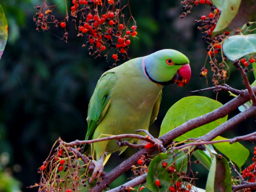

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

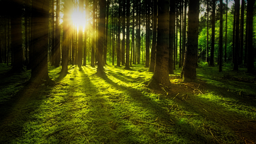

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Again, let me do this for land making it 3 categories

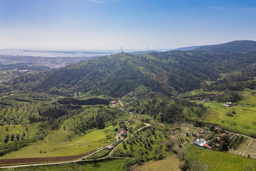

In [9]:
download_url(search_images('Land photos', max_images=1)[0], 'land.jpg', show_progress=False)
Image.open('land.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird", "Land" and "forest" photos, and save each group of photos to a different folder:

In [10]:
!sudo apt-get -qq update && sudo apt-get -qq install libavif-bin


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [11]:
!pip install -q pillow-avif-plugin   # gives you AVIF read/write through Pillow

In [12]:
!pip install pillow-avif-plugin


In [13]:
import pillow_avif
from PIL import Image


In [14]:
searches = 'forest','bird','land'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

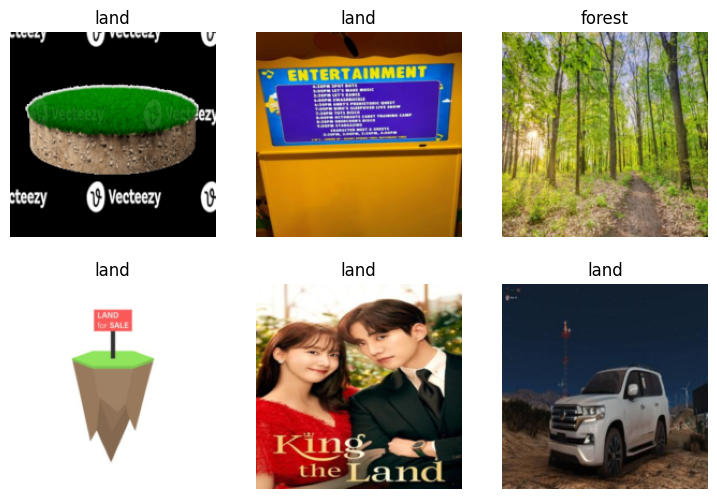

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.086673,0.488437,0.135922,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.414023,0.087884,0.029126,00:02
1,0.246528,0.024661,0.000000,00:02
2,0.156040,0.029376,0.019417,00:03


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [18]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [23]:
is_forest,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_forest}.")
print(f"Probability it's a Forest: {probs[1]:.4f}")

This is a: forest.
Probability it's a Forest: 0.9984


In [24]:
is_land,_,probs = learn.predict(PILImage.create('land.jpg'))
print(f"This is a: {is_land}.")
print(f"Probability it's a landd: {probs[2]:.4f}")

This is a: land.
Probability it's a landd: 0.8223


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [15]:
import os

# Construct the path to the 'land' directory
land_path = 'bird_or_not/land'

# Check if the directory exists
if os.path.exists(land_path):
    # List all entries in the directory and count them
    num_files = len(os.listdir(land_path))
    print(f"Number of files in '{land_path}': {num_files}")
else:
    print(f"The directory '{land_path}' does not exist.")

Number of files in 'bird_or_not/land': 70


In [17]:
import os

# Construct the path to the 'land' directory
bird_path = 'bird_or_not/bird'

# Check if the directory exists
if os.path.exists(bird_path):
    # List all entries in the directory and count them
    num_files = len(os.listdir(bird_path))
    print(f"Number of files in '{bird_path}': {num_files}")
else:
    print(f"The directory '{bird_path}' does not exist.")

Number of files in 'bird_or_not/bird': 95


In [18]:
import os

# Construct the path to the 'land' directory
forest_path = 'bird_or_not/forest'

# Check if the directory exists
if os.path.exists(forest_path):
    # List all entries in the directory and count them
    num_files = len(os.listdir(forest_path))
    print(f"Number of files in '{forest_path}': {num_files}")
else:
    print(f"The directory '{forest_path}' does not exist.")

Number of files in 'bird_or_not/forest': 95
